In [1]:
import scanpy as sc
import pandas as pd
import scipy.sparse
import numpy as np
import time

In [2]:
import tracemalloc

import os
print(os.getcwd()) 

/home/lp3038/capstone


In [3]:
adata = sc.read_h5ad("./human_adult_GRCh38-3.0.0.h5ad")

# Inspect the shape of the object
print(adata)
print("Number of observations (cells):", adata.n_obs)
print("Number of variables (genes):", adata.n_vars)


AnnData object with n_obs × n_vars = 3369219 × 33538
    obs: 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
Number of observations (cells): 3369219
Number of variables (genes): 33538


In [4]:
adata.var['mt'] = adata.var['Gene'].str.startswith('MT-')

adata.var["ribo"] = adata.var['Gene'].str.startswith(("RPS", "RPL"))

adata.var["hb"] = adata.var['Gene'].str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

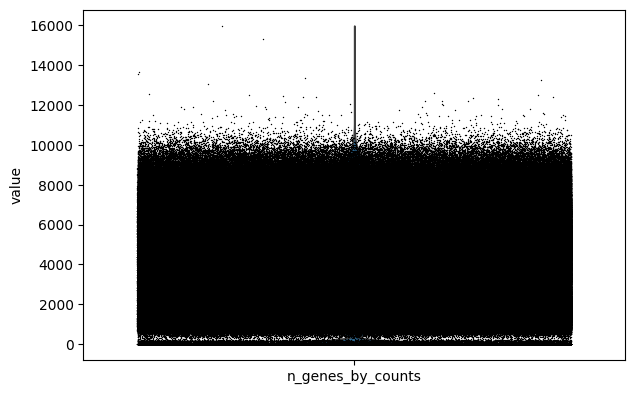

In [6]:
# sc.pl.violin(
#     adata,
#     ["n_genes_by_counts"],
#     jitter=0.4
# )

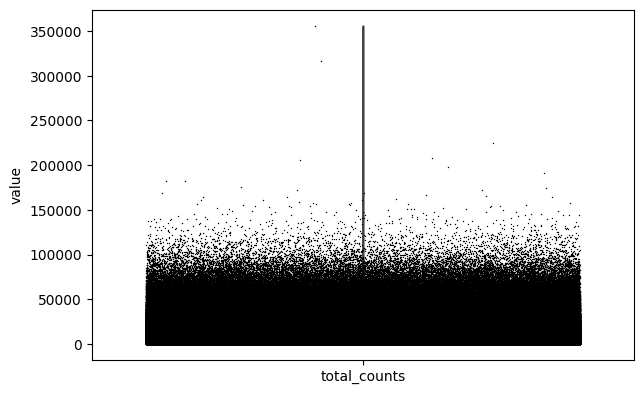

In [7]:
# sc.pl.violin(
#     adata,
#     ["total_counts"],
#     jitter=0.4
# )

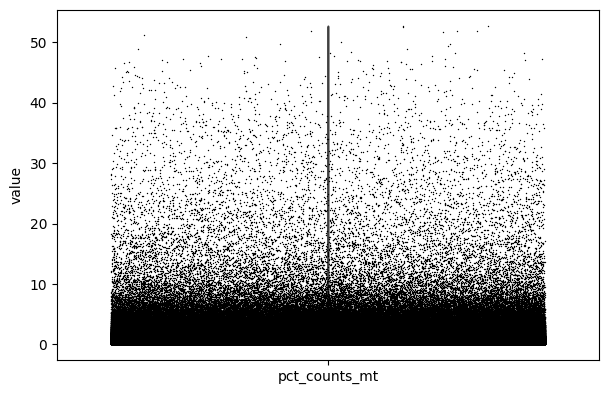

In [8]:
# sc.pl.violin(
#     adata,
#     ["pct_counts_mt"],
#     jitter=0.4
# )

In [6]:
# print(f"Mitochondrial genes: {adata.var['mt'].sum()}")
# print(f"Ribosomal genes: {adata.var['ribo'].sum()}")
# print(f"Hemoglobin genes: {adata.var['hb'].sum()}")

Mitochondrial genes: 13
Ribosomal genes: 104
Hemoglobin genes: 12


In [7]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_cells(adata, max_genes=12000)

sc.pp.filter_genes(adata, min_cells=3)

# Filter out cells with more than 40,000 total counts
adata = adata[adata.obs['total_counts'] <= 120000, :]

#  Filter out cells with more than 20% mitochondrial gene expression
adata = adata[adata.obs['pct_counts_mt'] <= 20, :]
# Check the number of cells remaining after filtering
print(f"Remaining cells after filtering: {adata.n_obs}")
print(f"Remaining genes after filtering: {adata.n_vars}")

Remaining cells after filtering: 3294442
Remaining genes after filtering: 32603


In [4]:
#adata.write_h5ad("qc_filtered.h5ad")
#adata = sc.read_h5ad("qc_filtered.h5ad")

In [5]:
#Normalization
adata.layers["counts"] = adata.X.copy()

In [6]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [7]:
#adata.write_h5ad("normalized.h5ad")

In [8]:
# Feature Selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="donor_id")

In [9]:
#adata.write_h5ad("hvg.h5ad")

In [22]:
# # Top 10 HVG: Sort by normalized variance (descending order)
# hvg_genes = adata.var[adata.var['highly_variable']]

# hvg_sorted = hvg_genes.sort_values(by='dispersions_norm', ascending=False)

# top_10_hvg = hvg_sorted.head(10)
# top_10_genes = top_10_hvg.index.tolist()

# print(top_10_genes)

['ENSG00000122585', 'ENSG00000101405', 'ENSG00000157005', 'ENSG00000101200', 'ENSG00000211592', 'ENSG00000118271', 'ENSG00000131095', 'ENSG00000275302', 'ENSG00000211899', 'ENSG00000077420']


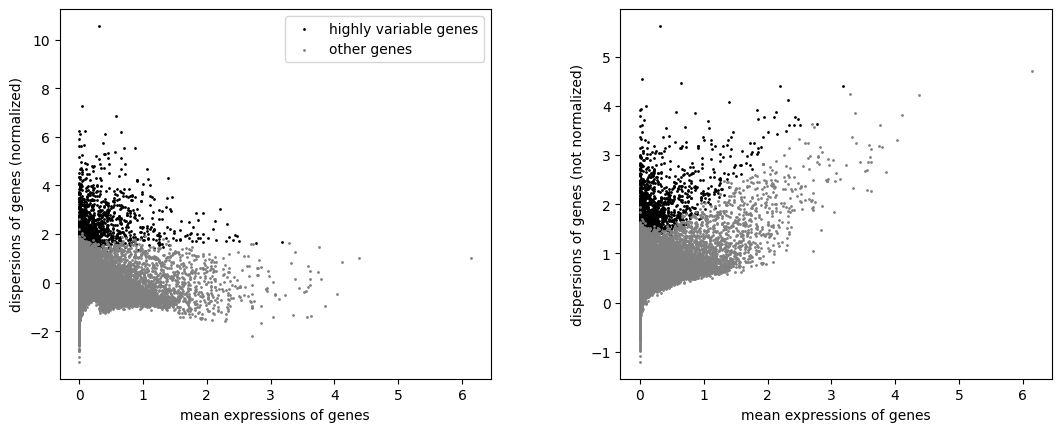

In [23]:
# sc.pl.highly_variable_genes(adata)

In [3]:
#adata = sc.read_h5ad("hvg.h5ad")

In [4]:
#Dimension Reduction
sc.tl.pca(adata)

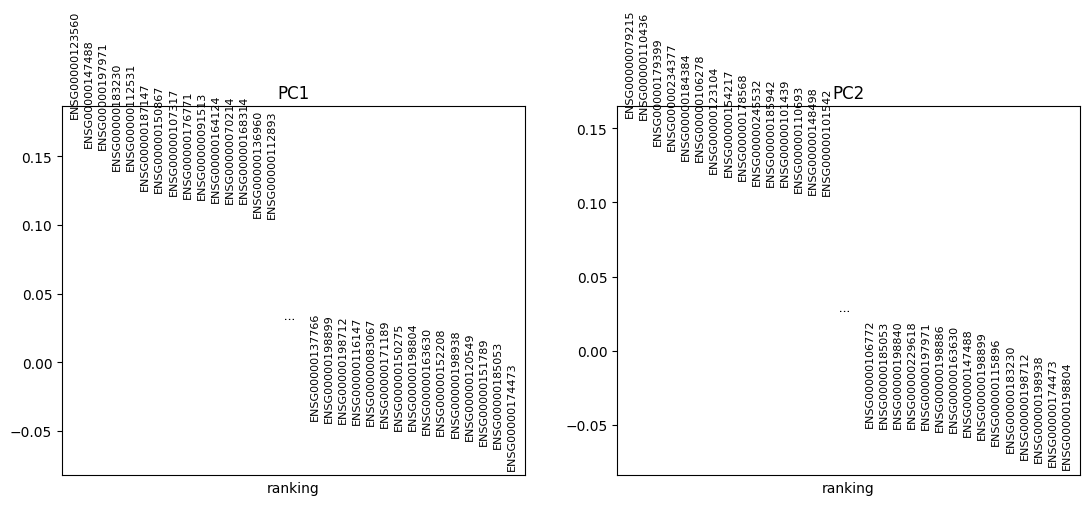

In [25]:
# #PCA Loading Plot
# sc.pl.pca_loadings(adata, components = '1,2')

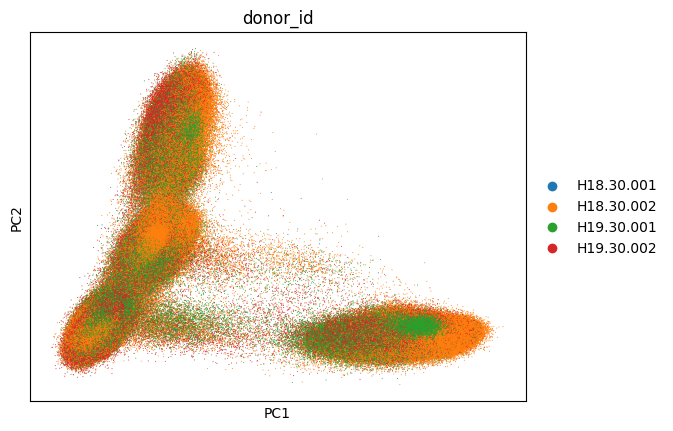

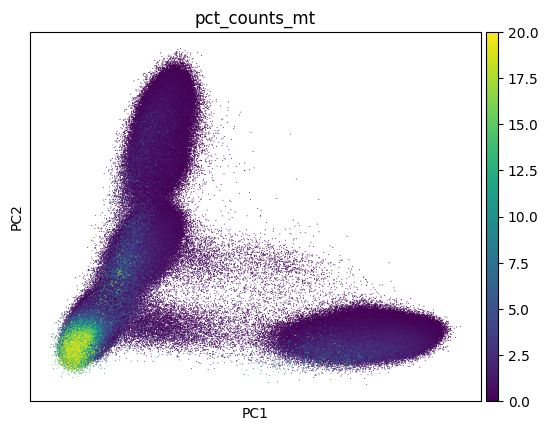

In [26]:
# #PCA Plot
# sc.pp.pca(adata)


# sc.pl.pca(adata, color='donor_id', size=2, show=True)


# sc.pl.pca(adata, color='pct_counts_mt', size=2, show=True)

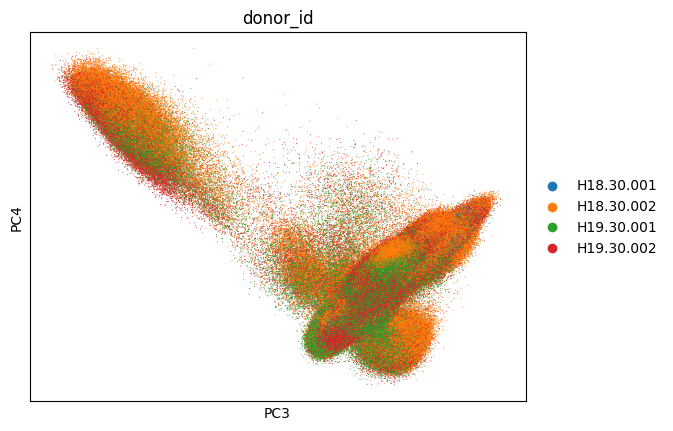

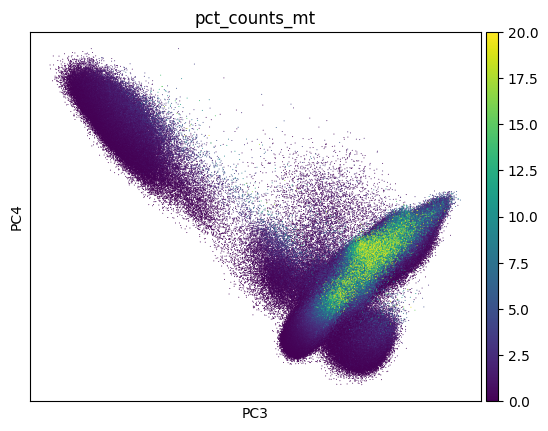

In [27]:
# # PCA colored by sample_id for PC3 vs PC4
# sc.pl.pca(adata, color='donor_id', components=['3, 4'], size=2, show=True)

# # Plot PCA colored by pct_counts_mt for PC3 vs PC4
# sc.pl.pca(adata, color='pct_counts_mt', components=['3, 4'], size=2, show=True)

In [5]:
#Nearest Neighbor Construction
sc.pp.neighbors(adata, use_rep='X_pca')

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [6]:
#UMAP Construction
sc.tl.umap(adata)

In [7]:
#adata.write_h5ad("preprocessed_full_adata.h5ad")

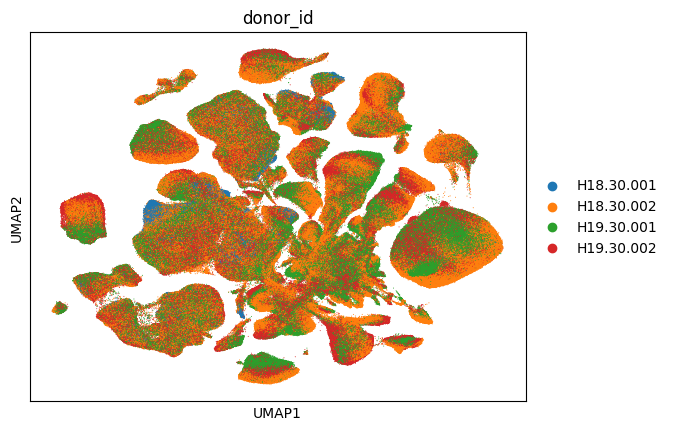

In [30]:
# sc.pl.umap(
#     adata,
#     color="donor_id",
#     size=2,
# )

In [31]:
#Clustering: Leiden
tracemalloc.start()
start_time = time.time()

sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

current, peak = tracemalloc.get_traced_memory()
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB")
print(f"Time taken: {elapsed_time} seconds")
tracemalloc.stop()

Current memory usage: 3.426228 MB
Peak memory usage: 9457.552344 MB
Time taken: 666.7027637958527 seconds


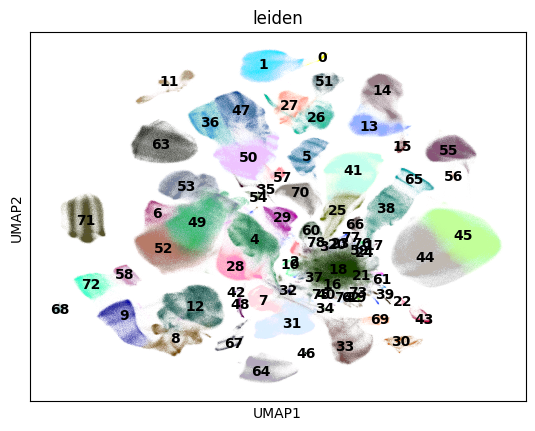

In [32]:
sc.pl.umap(adata, color=["leiden"],legend_loc="on data")

In [33]:
#Clustering: Louvain
tracemalloc.start()
start_time = time.time()

sc.tl.louvain(adata, flavor="igraph")#, resolution=1.0

current, peak = tracemalloc.get_traced_memory()
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB")
print(f"Time taken: {elapsed_time} seconds")
tracemalloc.stop()

Current memory usage: 3.425364 MB
Peak memory usage: 9457.53776 MB
Time taken: 1846.014403104782 seconds


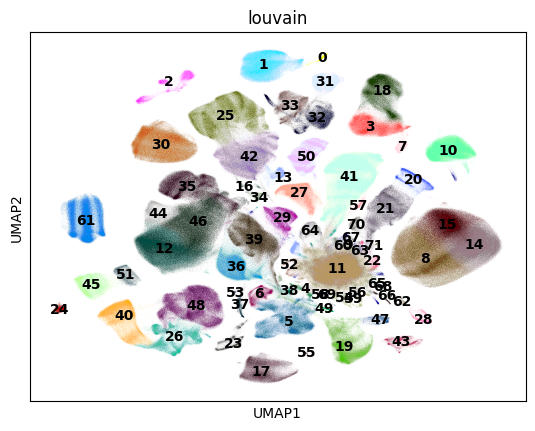

In [34]:
sc.pl.umap(adata, color='louvain',legend_loc="on data")

In [35]:
import phenograph
import matplotlib.pyplot as plt
import scanpy.external

In [ ]:
# Phenograph clustering (Louvain)
tracemalloc.start()
start_time = time.time()

scanpy.external.tl.phenograph(adata, clustering_algo="louvain", k = 15)

current, peak = tracemalloc.get_traced_memory()
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB")
print(f"Time taken: {elapsed_time} seconds")
tracemalloc.stop()

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1629.7018339633942 seconds


In [ ]:
adata.obs['pheno_louvain'] = adata.obs['pheno_louvain'].astype(str)
sc.pl.umap(adata,
           color='pheno_louvain',
           legend_loc='on data',
          legend_fontsize = 'small'
)

In [ ]:
# Phenograph clustering (Leiden)
tracemalloc.start()
start_time = time.time()

scanpy.external.tl.phenograph(adata, clustering_algo="leiden", k = 15, n_iterations = 2, louvain_time_limit = 2000)

current, peak = tracemalloc.get_traced_memory()
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB")
print(f"Time taken: {elapsed_time} seconds")
tracemalloc.stop()

In [ ]:
adata.obs['pheno_leiden'] = adata.obs['pheno_leiden'].astype(str)
sc.pl.umap(adata,
           color='pheno_leiden',
           legend_loc='on data',
          legend_fontsize = 'small'
)

In [ ]:
#Hierachical Clustering
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.dendrogram(adata, groupby='leiden')

In [ ]:
sc.tl.dendrogram(adata, groupby='louvain')
sc.pl.dendrogram(adata, groupby='louvain')

In [ ]:
#Hierachical Clustering for Phenograph using Louvain algorithm for community detection
sc.tl.dendrogram(adata, groupby='pheno_louvain')
sc.pl.dendrogram(adata, groupby='pheno_louvain')

In [ ]:
#Hierachical Clustering for Phenograph using Leiden algorithm with 2 iteration for community detection
sc.tl.dendrogram(adata, groupby='pheno_leiden')
sc.pl.dendrogram(adata, groupby='pheno_leiden')

In [ ]:
#Clustering Comparison

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [ ]:
pheno_leiden_labels = adata.obs['pheno_leiden']
pheno_louvain_labels = adata.obs['pheno_louvain']
louvain_labels = adata.obs['louvain']
leiden_labels = adata.obs['leiden']

In [ ]:
clustering_labels = [
    ('Louvain', louvain_labels),
    ('Leiden', leiden_labels),
    ('Phenograph(Louvain)', pheno_louvain_labels),
    ('Phenograph(Leiden)', pheno_leiden_labels)
]

In [ ]:
comparisons = pd.DataFrame(index=['Louvain', 'Leiden', 'Phenograph(Louvain)', 'Phenograph(Leiden)'],
                           columns=['Louvain', 'Leiden', 'Phenograph(Louvain)', 'Phenograph(Leiden)'])

In [ ]:
print("Pairwise Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI):")
for i, (name_1, labels_1) in enumerate(clustering_labels):
    for j, (name_2, labels_2) in enumerate(clustering_labels):
        if i < j:  # Compare only unique pairs
            nmi = normalized_mutual_info_score(labels_1, labels_2)
            ari = adjusted_rand_score(labels_1, labels_2)
            comparisons.loc[name_1, name_2] = f'NMI: {nmi:.4f}, ARI: {ari:.4f}'
            comparisons.loc[name_2, name_1] = f'NMI: {nmi:.4f}, ARI: {ari:.4f}'
            print(f'{name_1} vs {name_2} - NMI: {nmi:.4f}, ARI: {ari:.4f}')

# Display the DataFrame
print("\nPairwise Comparison Results:")
print(comparisons)

In [ ]:
#scANVI

In [ ]:
# We run highly variable gene selection on the reference data and use these same genes for the query data.

# sc.pp.highly_variable_genes(pancreas_ref, n_top_genes=2000, batch_key="tech", subset=True)

# pancreas_query = pancreas_query[:, pancreas_ref.var_names].copy()


In [2]:
import scvi
import anndata as ad
import pandas as pd
from scvi.model import SCANVI

Global seed set to 0


In [9]:
# Load the Loom file containing scCATCH annotations
reference_adata = ad.read_loom("scCATCH_data.loom")

print(reference_adata)

AnnData object with n_obs × n_vars = 50000 × 30042
    obs: 'Louvain_Clusters', 'RNA_snn_res.1', 'Tissue', 'TotalUMIs', 'annotated_cell_type', 'assay_ontology_term_id', 'cluster_id', 'cluster_marker', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'dissection', 'donor_id', 'hb', 'mt', 'nCount_RNA', 'nFeature_RNA', 'organism_ontology_term_id', 'orig.ident', 'percent.hb', 'percent.mt', 'percent.ribo', 'ribo', 'roi', 'sample_id', 'self_reported_ethnicity_ontology_term_id', 'seurat_clusters', 'sex_ontology_term_id', 'suspension_type', 'total_UMIs'


In [15]:
import loompy

# Open the Loom file
loom_file = loompy.connect("scCATCH_annotated.loom", mode="r")
print(loom_file.ca.keys())  # Column attributes (e.g., metadata)
print(loom_file.layers.keys())  # Layers


['CellID', 'Louvain_Clusters', 'RNA_snn_res.1', 'Tissue', 'TotalUMIs', 'annotated_cell_type', 'assay_ontology_term_id', 'cluster_id', 'cluster_marker', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'dissection', 'donor_id', 'hb', 'mt', 'nCount_RNA', 'nFeature_RNA', 'organism_ontology_term_id', 'orig.ident', 'percent.hb', 'percent.mt', 'percent.ribo', 'ribo', 'roi', 'sample_id', 'self_reported_ethnicity_ontology_term_id', 'seurat_clusters', 'sex_ontology_term_id', 'suspension_type', 'total_UMIs']
['']


In [10]:
# Check the column names in `obs`
print(reference_adata.obs.columns)

Index(['Louvain_Clusters', 'RNA_snn_res.1', 'Tissue', 'TotalUMIs',
       'annotated_cell_type', 'assay_ontology_term_id', 'cluster_id',
       'cluster_marker', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'dissection', 'donor_id', 'hb', 'mt',
       'nCount_RNA', 'nFeature_RNA', 'organism_ontology_term_id', 'orig.ident',
       'percent.hb', 'percent.mt', 'percent.ribo', 'ribo', 'roi', 'sample_id',
       'self_reported_ethnicity_ontology_term_id', 'seurat_clusters',
       'sex_ontology_term_id', 'suspension_type', 'total_UMIs'],
      dtype='object')


In [12]:
# Rename the column with cell type annotations to "cell_type" (if necessary)
reference_adata.obs.rename(columns={"annotated_cell_type": "cell_type"}, inplace=True)
# Verify the annotations
print(reference_adata.obs["cell_type"].unique())

['Astrocyte'
 'Astrocyte, Interneuron, Lake Et Al.science.ex1, Lake Et Al.science.ex8, Lake Et Al.science.in4, Microglial Cell, Neuron, Pericyte'
 'Microglial Cell' 'NA' 'Astrocyte, Lake Et Al.science.ex8'
 'Oligodendrocyte' 'Oligodendrocyte, Progenitor Cell' 'Progenitor Cell'
 'Neural Progenitor Cell' 'Astrocyte, Oligodendrocyte']


In [ ]:
query_adata = sc.read_h5ad("preprocessed_full_adata.h5ad")  # Replace with the path to your query data

# Inspect the query AnnData object
print(query_adata)

In [13]:
scvi.model.SCVI.setup_anndata(reference_adata, batch_key="donor_id", layer="counts")

/opt/conda/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [ ]:
scvi_ref = scvi.model.SCVI(
    reference_adata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,  # Use additional covariates, e.g., batch effects
    dropout_rate=0.2,        # Dropout for regularization
    n_layers=2               # Number of hidden layers
)

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
reference_adata.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()

In [ ]:
scvi_ref_path = os.path.join(save_dir.name, "human_scvi_ref")
scvi_ref.save(scvi_ref_path, overwrite=True)
scvi.model.SCVI.prepare_query_anndata(query_adata, scvi_ref)

In [ ]:
#query model
scvi_query = scvi.model.SCVI.load_query_data(
    pancreas_query,
    scvi_ref,
)

In [17]:
#train query
scvi_query.train(max_epochs=200, plan_kwargs={"weight_decay": 0.0})
pancreas_query.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()

In [ ]:
# Predict cell types for all cells in the combined dataset
predictions = scanvi_model.predict()

# Add predictions back to the query dataset
query_adata.obs["predicted_cell_type"] = predictions[combined_adata.obs["dataset"] == "query"]

# Save the annotated query dataset
query_adata.write_h5ad("annotated_query_data.h5ad")
